In [51]:
# A rewrite of the code to make it easier to deal with. 
# We now allow for a multi-grid solver with uneven lengths and different resolutions.
# State vector: [t, ξ, p_2, a_4], var_vec.
# var_vec: Phi, S, Sdot, PhiDot, A.
T = Float64;

# --------------------------------------------------------------
#  Struct definition: this holds all variables at a grid point.
# --------------------------------------------------------------

struct PDEVars{T}
    Phi::T
    S::T
    Sdot::T
    Phidot::T
    A::T
    PhiZ::T
    SZ::T
    SdotZ::T
    PhidotZ::T
    AZ::T
    PhiZZ::T
    SZZ::T
    SdotZZ::T
    PhidotZZ::T
    AZZ::T
    z::T
    LN::T
    t::T
    X::T
    p2::T
    a4::T
    DS0::T
    DS1::T
    DS2::T
    DS3::T
    DS4::T
end

# setprecision(T, 512);
using Plots
using Parameters: @unpack

include("cheb.jl")
include("Equation expressions/ODECoeffExpr.jl");
include("Equation expressions/FlatS0Expr.jl");
include("Equation expressions/CosmoTimeStepExpr.jl");
include("Equation expressions/CosmoConstrExpr.jl");
include("solvers.jl")

#Properties of this simulation:

global const H = T(3.);
global const Om = T(4.);
global const tstar = 1;
global const M = T(1.);
global zAH = T(1/2);

global const z_boundaries = [zero(T), T(0.15), T(0.3), T(0.5), T(0.6)]; #Boundaries of grid domains.
global const domain_sizes = [15, 15, 15, 15]; #sizes of all domains.
global const Ndom = length(domain_sizes);
global const N = sum(domain_sizes);

global const zero_var = [zeros(T,n) for n in domain_sizes]; #Helpful for getting arrays of the right shape

diff2_mats, diff1_mats, grids, damp_mats = MultiGridChebyshev(z_boundaries,domain_sizes);

Vfun(x) = ( -576. - 288. * x^2 - 64. * x^4 + 22. * x^6 - x^8) / 192.;
DV(x) = - x * (144. + 64. * x^2 - 33. * x^4 + 2. * x^6) / 48.;


LoadError: BoundsError: attempt to access Tuple{Vector{Any}, Vector{Any}, Vector{Any}} at index [4]

In [2]:
init_guess = [copy(zero_var) for var in 1:NVar];
Var = copy(init_guess);

In [3]:
init_params = [T(-3), T(0.), 0, -T(100.)];
init_guess = [copy(zero_var) for var in 1:NVar];


In [4]:

Var = copy(init_guess);
VarZ,VarZZ = ComputeDerivatives(Var);

for ii in 1:500
    Var[ind_s] = LinearSolveODE(1, init_params, Var, VarZ, VarZZ);
    VarZ[ind_s] = ComputeSingleDerivative(Var[ind_s]);
    VarZZ[ind_s] = ComputeSingleDerivative(Var[ind_s], deg=2);

    Var[ind_sdot] = LinearSolveODE(2, init_params, Var, VarZ, VarZZ);
    VarZ[ind_sdot] = ComputeSingleDerivative(Var[ind_sdot]);
    VarZZ[ind_sdot] = ComputeSingleDerivative(Var[ind_sdot], deg=2);

    newX = CorrectXi(init_params, Var);
    print("\rX = $newX");
    flush(stdout);

    init_params[ind_X] = newX;
end

X = 1.0184513904106285

In [5]:
InitVar = ComputeBulk(init_params, Var);

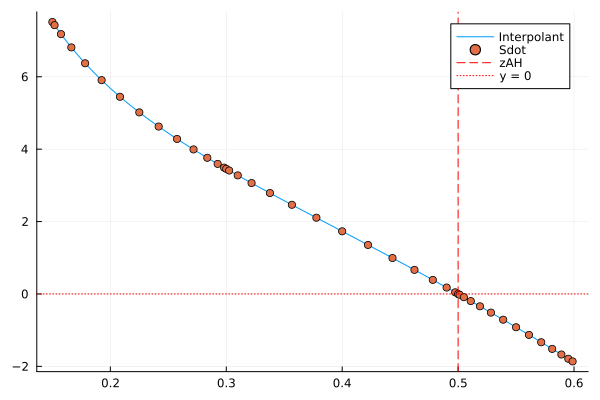

In [6]:
fig = PlotSdot(init_params,Var);
display(fig)

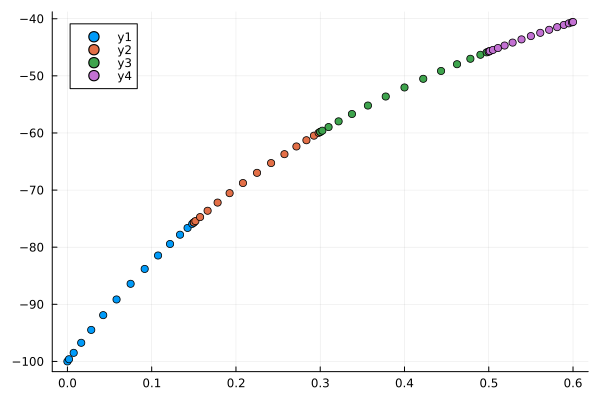

In [7]:
scatter(grids,InitVar[5])

In [41]:
dt = T(.0001);


outfile = [];
monitorfile = [];

VarFinal, XFinal, a4Final = Evolve(init_params,InitVar, 0, dt, 100, outfile, monitorfile);

# close(outfile);
# close(monitorfile);

◒ t = -0.021    Time: 0:02:12

LoadError: TaskFailedException

[91m    nested task error: [39mArgumentError: matrix contains Infs or NaNs
    Stacktrace:
      [1] [0m[1mchkfinite[22m
    [90m    @[39m [90m~/.julia/juliaup/julia-1.12.1+0.aarch64.apple.darwin14/share/julia/stdlib/v1.12/LinearAlgebra/src/[39m[90m[4mlapack.jl:105[24m[39m[90m [inlined][39m
      [2] [0m[1mgetrf![22m[0m[1m([22m[90mA[39m::[0mMatrix[90m{Float64}[39m, [90mipiv[39m::[0mVector[90m{Int64}[39m; [90mcheck[39m::[0mBool[0m[1m)[22m
    [90m    @[39m [36mLinearAlgebra.LAPACK[39m [90m~/.julia/juliaup/julia-1.12.1+0.aarch64.apple.darwin14/share/julia/stdlib/v1.12/LinearAlgebra/src/[39m[90m[4mlapack.jl:582[24m[39m
      [3] [0m[1mgetrf![22m
    [90m    @[39m [90m~/.julia/juliaup/julia-1.12.1+0.aarch64.apple.darwin14/share/julia/stdlib/v1.12/LinearAlgebra/src/[39m[90m[4mlapack.jl:580[24m[39m[90m [inlined][39m
      [4] [0m[1mgetrf![22m
    [90m    @[39m [90m~/.julia/juliaup/julia-1.12.1+0.aarch64.apple.darwin14/share/julia/stdlib/v1.12/LinearAlgebra/src/[39m[90m[4mlapack.jl:787[24m[39m[90m [inlined][39m
      [5] [0m[1m#lu!#180[22m
    [90m    @[39m [90m~/.julia/juliaup/julia-1.12.1+0.aarch64.apple.darwin14/share/julia/stdlib/v1.12/LinearAlgebra/src/[39m[90m[4mlu.jl:91[24m[39m[90m [inlined][39m
      [6] [0m[1mlu![22m
    [90m    @[39m [90m~/.julia/juliaup/julia-1.12.1+0.aarch64.apple.darwin14/share/julia/stdlib/v1.12/LinearAlgebra/src/[39m[90m[4mlu.jl:90[24m[39m[90m [inlined][39m
      [7] [0m[1mlu![22m
    [90m    @[39m [90m~/.julia/juliaup/julia-1.12.1+0.aarch64.apple.darwin14/share/julia/stdlib/v1.12/LinearAlgebra/src/[39m[90m[4mlu.jl:89[24m[39m[90m [inlined][39m
      [8] [0m[1m_lu[22m
    [90m    @[39m [90m~/.julia/juliaup/julia-1.12.1+0.aarch64.apple.darwin14/share/julia/stdlib/v1.12/LinearAlgebra/src/[39m[90m[4mlu.jl:347[24m[39m[90m [inlined][39m
      [9] [0m[1mlu[22m[0m[1m([22m::[0mMatrix[90m{Float64}[39m; [90mkwargs[39m::[0m@Kwargs[90m{}[39m[0m[1m)[22m
    [90m    @[39m [36mLinearAlgebra[39m [90m~/.julia/juliaup/julia-1.12.1+0.aarch64.apple.darwin14/share/julia/stdlib/v1.12/LinearAlgebra/src/[39m[90m[4mlu.jl:341[24m[39m
     [10] [0m[1mlu[22m[0m[1m([22m::[0mMatrix[90m{Float64}[39m[0m[1m)[22m
    [90m    @[39m [36mLinearAlgebra[39m [90m~/.julia/juliaup/julia-1.12.1+0.aarch64.apple.darwin14/share/julia/stdlib/v1.12/LinearAlgebra/src/[39m[90m[4mlu.jl:341[24m[39m
     [11] [0m[1mmacro expansion[22m
    [90m    @[39m [90m~/Documents/Holography with dynamic boundary/Reproducing-Dynamic-Holo/[39m[90m[4msolvers.jl:315[24m[39m[90m [inlined][39m
     [12] [0m[1m(::var"#LinearSolveODE##16#LinearSolveODE##17"{var"#LinearSolveODE##18#LinearSolveODE##19"{Int64, Vector{Float64}, Vector{Vector{Vector{Float64}}}, Vector{Vector{Vector{Float64}}}, Vector{Vector{Vector{Float64}}}, Vector{Vector{Float64}}, Vector{Vector{Float64}}, Int64, UnitRange{Int64}}})[22m[0m[1m([22m[90mtid[39m::[0mInt64; [90monethread[39m::[0mBool[0m[1m)[22m
    [90m    @[39m [35mMain[39m [90m./[39m[90m[4mthreadingconstructs.jl:276[24m[39m
     [13] [0m[1m#LinearSolveODE##16[22m
    [90m    @[39m [90m./[39m[90m[4mthreadingconstructs.jl:243[24m[39m[90m [inlined][39m
     [14] [0m[1m(::Base.Threads.var"#threading_run##0#threading_run##1"{var"#LinearSolveODE##16#LinearSolveODE##17"{var"#LinearSolveODE##18#LinearSolveODE##19"{Int64, Vector{Float64}, Vector{Vector{Vector{Float64}}}, Vector{Vector{Vector{Float64}}}, Vector{Vector{Vector{Float64}}}, Vector{Vector{Float64}}, Vector{Vector{Float64}}, Int64, UnitRange{Int64}}}, Int64})[22m[0m[1m([22m[0m[1m)[22m
    [90m    @[39m [90mBase.Threads[39m [90m./[39m[90m[4mthreadingconstructs.jl:177[24m[39m

In [44]:
length(outfile)

297

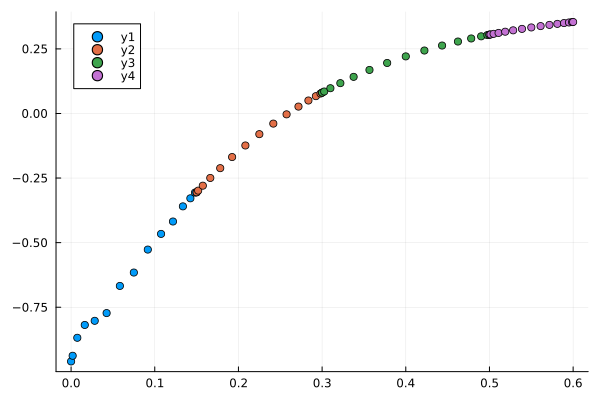

In [49]:
scatter(grids,outfile[130][1])

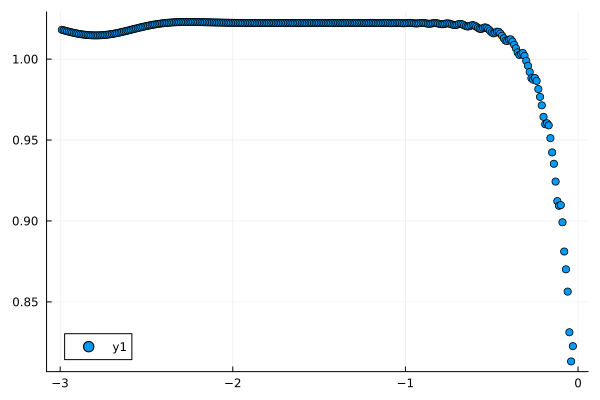

In [48]:
scatter([x[1] for x in monitorfile],[x[2] for x in monitorfile])

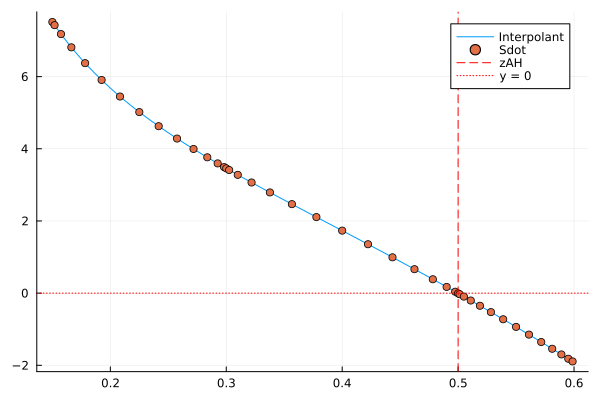

In [40]:
fig = PlotSdot(init_params,outfile[end]);
display(fig)